# 향상된 데이터 분석 에이전트
## 주택 가격 예측 데이터셋 분석

이 노트북은 LangChain의 pandas 데이터프레임 에이전트를 사용하여 주택 가격 데이터를 분석합니다.

In [ ]:
# 필요한 라이브러리 설치
# !pip install langchain langchain-experimental langchain-openai pandas matplotlib seaborn numpy scikit-learn python-dotenv

In [ ]:
# 환경 변수에서 API 키 가져오기
import os
import warnings
from dotenv import load_dotenv

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    print(" OPENAI_API_KEY가 설정되지 않았습니다. .env 파일을 확인해주세요.")
else:
    print("OpenAI API 키가 성공적으로 로드되었습니다.")

OpenAI API 키가 성공적으로 로드되었습니다.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# pandas 옵션 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

In [ ]:
# 데이터 로드
try:
    train = pd.read_csv('./data/house/train.csv')
    test = pd.read_csv('./data/house/test.csv')
    print(f"훈련 데이터 로드 완료: {train.shape}")
    print(f"테스트 데이터 로드 완료: {test.shape}")
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다. './data/' 폴더에 train.csv와 test.csv 파일이 있는지 확인해주세요.")
    # 임시로 샘플 데이터 생성
    train = pd.DataFrame({
        'Id': range(1, 101),
        'LotArea': np.random.randint(5000, 20000, 100),
        'OverallQual': np.random.randint(1, 11, 100),
        'GrLivArea': np.random.randint(800, 3000, 100),
        'SalePrice': np.random.randint(100000, 500000, 100)
    })
    test = train.drop('SalePrice', axis=1).head(50)
    print("샘플 데이터를 생성했습니다.")

훈련 데이터 로드 완료: (1460, 81)
테스트 데이터 로드 완료: (1459, 80)


In [18]:
# 기본 데이터 정보 확인
print("=== 훈련 데이터 기본 정보 ===")
print(train.info())
print(f"데이터 크기: {train.shape}")
print(f"결측값 총 개수:\n {train.isnull().sum()}")
print(f"중복된 행: {train.duplicated().sum()}")


=== 훈련 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   

In [20]:
for idx, col_name in enumerate(train.columns) :
    missingValueRate = train[col_name].isna().sum() / len(train) * 100
    if missingValueRate > 0 :
        print(f"{idx} {col_name} null rate: {round(missingValueRate, 2)}%")

3 LotFrontage null rate: 17.74%
6 Alley null rate: 93.77%
25 MasVnrType null rate: 59.73%
26 MasVnrArea null rate: 0.55%
30 BsmtQual null rate: 2.53%
31 BsmtCond null rate: 2.53%
32 BsmtExposure null rate: 2.6%
33 BsmtFinType1 null rate: 2.53%
35 BsmtFinType2 null rate: 2.6%
42 Electrical null rate: 0.07%
57 FireplaceQu null rate: 47.26%
58 GarageType null rate: 5.55%
59 GarageYrBlt null rate: 5.55%
60 GarageFinish null rate: 5.55%
63 GarageQual null rate: 5.55%
64 GarageCond null rate: 5.55%
72 PoolQC null rate: 99.52%
73 Fence null rate: 80.75%
74 MiscFeature null rate: 96.3%


In [22]:

print("\n=== 테스트 데이터 기본 정보 ===")
print(test.info())
print(f"데이터 크기: {test.shape}")
print(f"결측값 총 개수: {test.isnull().sum()}")
print(f"중복된 행: {test.duplicated().sum()}")



=== 테스트 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null 

In [24]:
for idx, col_name in enumerate(test.columns) :
    missingValueRate = test[col_name].isna().sum() / len(test) * 100
    if missingValueRate > 0 :
        print(f"{idx} {col_name} null rate: {round(missingValueRate, 2)}%")

2 MSZoning null rate: 0.27%
3 LotFrontage null rate: 15.56%
6 Alley null rate: 92.67%
9 Utilities null rate: 0.14%
23 Exterior1st null rate: 0.07%
24 Exterior2nd null rate: 0.07%
25 MasVnrType null rate: 61.27%
26 MasVnrArea null rate: 1.03%
30 BsmtQual null rate: 3.02%
31 BsmtCond null rate: 3.08%
32 BsmtExposure null rate: 3.02%
33 BsmtFinType1 null rate: 2.88%
34 BsmtFinSF1 null rate: 0.07%
35 BsmtFinType2 null rate: 2.88%
36 BsmtFinSF2 null rate: 0.07%
37 BsmtUnfSF null rate: 0.07%
38 TotalBsmtSF null rate: 0.07%
47 BsmtFullBath null rate: 0.14%
48 BsmtHalfBath null rate: 0.14%
53 KitchenQual null rate: 0.07%
55 Functional null rate: 0.14%
57 FireplaceQu null rate: 50.03%
58 GarageType null rate: 5.21%
59 GarageYrBlt null rate: 5.35%
60 GarageFinish null rate: 5.35%
61 GarageCars null rate: 0.07%
62 GarageArea null rate: 0.07%
63 GarageQual null rate: 5.35%
64 GarageCond null rate: 5.35%
72 PoolQC null rate: 99.79%
73 Fence null rate: 80.12%
74 MiscFeature null rate: 96.5%
78 SaleT

In [25]:

# 공통 컬럼과 차이점 확인
train_cols = set(train.columns)
test_cols = set(test.columns)
common_cols = train_cols.intersection(test_cols)
train_only = train_cols - test_cols
test_only = test_cols - train_cols

print(f"\n=== 컬럼 비교 ===")
print(f"공통 컬럼: {len(common_cols)}개")
print(f"훈련 데이터에만 있는 컬럼: {train_only}")
print(f"테스트 데이터에만 있는 컬럼: {test_only}")


=== 컬럼 비교 ===
공통 컬럼: 80개
훈련 데이터에만 있는 컬럼: {'SalePrice'}
테스트 데이터에만 있는 컬럼: set()


In [26]:
# 데이터 전처리 함수
def preprocess_data(df, is_train=True):
    """데이터 전처리 함수"""
    df_processed = df.copy()
    
    # 수치형 컬럼의 결측값을 중앙값으로 채우기
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # 범주형 컬럼의 결측값을 'Unknown'으로 채우기
    categorical_cols = df_processed.select_dtypes(include=[object]).columns
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna('Unknown', inplace=True)
    
    return df_processed

# 데이터 전처리 적용
train_processed = preprocess_data(train, is_train=True)
test_processed = preprocess_data(test, is_train=False)

print("데이터 전처리가 완료되었습니다.")
print(f"훈련 데이터 결측값: {train_processed.isnull().sum().sum()}")
print(f"테스트 데이터 결측값: {test_processed.isnull().sum().sum()}")

데이터 전처리가 완료되었습니다.
훈련 데이터 결측값: 0
테스트 데이터 결측값: 0


In [ ]:
# LangChain 에이전트 설정
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI

# LLM 초기화
llm = ChatOpenAI(
    #model='gpt-3.5-turbo-0125', 
    model='gpt-4o-mini',
    temperature=0,
    api_key=OPENAI_API_KEY
)

# 훈련 데이터용 에이전트 생성
train_agent = create_pandas_dataframe_agent(
    llm,
    train_processed,
    #agent_type="openai-tools",
    agent_type="tool-calling",
    verbose=True,
    return_intermediate_steps=False,
    allow_dangerous_code=True,
    prefix="""당신은 주택 가격 예측 데이터셋을 분석하는 전문가입니다. 
    데이터프레임의 이름은 'df'입니다. 한국어로 답변해주세요.
    시각화를 요청받으면 matplotlib를 사용하여 깔끔하고 이해하기 쉬운 그래프를 만들어주세요."""
)

# 테스트 데이터용 에이전트 생성
test_agent = create_pandas_dataframe_agent(
    llm,
    test_processed,
    agent_type="openai-tools",
    verbose=False,
    return_intermediate_steps=False,
    allow_dangerous_code=True,
    prefix="""당신은 테스트 데이터셋을 분석하는 전문가입니다. 
    데이터프레임의 이름은 'df'입니다. 한국어로 답변해주세요."""
)

print("LangChain 에이전트가 성공적으로 생성되었습니다.")

LangChain 에이전트가 성공적으로 생성되었습니다.


## 기본 데이터 탐색

In [30]:
# 기본 통계 정보 확인
response = train_agent.invoke('데이터의 기본 통계 정보를 보여주세요. 특히 SalePrice에 대한 정보를 자세히 설명해주세요.')
print(response['output'])



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'df.describe()'}`


                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    69.863699   10516.828082     6.099315   
std     421.610009    42.300571    22.027677    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.117123  



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'import matplotlib.pyplot as plt'}`



Invoking: `python_repl_ast` with `{'query': 'import seaborn as sns'}`



Invoking: `python_repl_ast` with `{'query': "plt.figure(figsize=(15, 6))\n\nplt.subplot(1, 2, 1)\nsns.histplot(df['SalePrice'], bins=50, kde=True)\nplt.title('SalePrice 히스토그램')\nplt.xlabel('가격')\nplt.ylabel('빈도')\n\nplt.subplot(1, 2, 2)\nsns.boxplot(y=df['SalePrice'])\nplt.title('SalePrice 박스플롯')\nplt.ylabel('가격')\n\nplt.tight_layout()\nplt.show()"}`




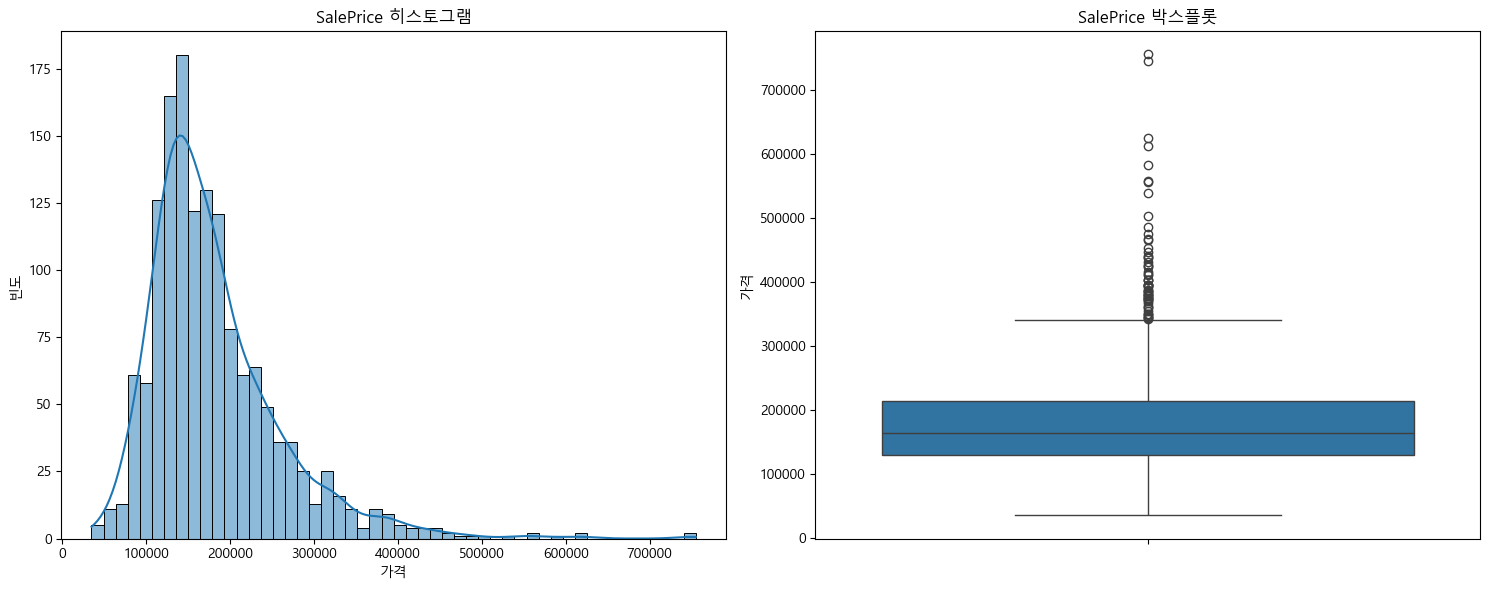


Invoking: `python_repl_ast` with `{'query': "df['SalePrice'].describe()"}`
responded: 위의 코드를 실행한 결과, SalePrice의 분포를 나타내는 히스토그램과 박스플롯이 시각화되었습니다. 이제 기본 통계량을 출력해보겠습니다.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64SalePrice의 기본 통계량은 다음과 같습니다:
- 평균(Mean): \$180,921.20
- 표준편차(Standard Deviation): \$79,442.50
- 최솟값(Min): \$34,900.00
- 25백분위수(1st Quartile): \$129,975.00
- 중앙값(Median): \$163,000.00
- 75백분위수(3rd Quartile): \$214,000.00
- 최댓값(Max): \$755,000.00

히스토그램과 박스플롯을 통해 SalePrice의 분포를 시각화하고, 기본 통계량을 확인했습니다.

> Finished chain.
SalePrice의 기본 통계량은 다음과 같습니다:
- 평균(Mean): \$180,921.20
- 표준편차(Standard Deviation): \$79,442.50
- 최솟값(Min): \$34,900.00
- 25백분위수(1st Quartile): \$129,975.00
- 중앙값(Median): \$163,000.00
- 75백분위수(3rd Quartile): \$214,000.00
- 최댓값(Max): \$755,000.00

히스토그램과 박스플롯을 통해 SalePrice의 분포를 시각화하고, 기본 통계량을 확인했습니다.

In [33]:
# 주택 가격 분포 시각화
response = train_agent.invoke("""
SalePrice의 분포를 다음과 같이 시각화해주세요:
1. 히스토그램 (bins=50)
2. 박스플롯
3. 기본 통계량 출력

그래프는 한국어 제목과 라벨을 사용하고, 서브플롯으로 구성해주세요.
""")
print(response['output'])



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Calculate missing values ratio for each column\nmissing_ratio = df.isnull().mean()\n\n# Sort columns based on missing values ratio\ntop_10_columns = missing_ratio.sort_values(ascending=False).head(10)\n\n# Plot bar graph\nplt.figure(figsize=(12, 6))\nplt.bar(top_10_columns.index, top_10_columns.values)\nplt.xlabel('Columns')\nplt.ylabel('Missing Values Ratio')\nplt.title('Top 10 Columns with Highest Missing Values Ratio')\nplt.xticks(rotation=45)\nplt.show()\n\n# Return top 10 columns and their missing values ratio\n(top_10_columns, top_10_columns.values)"}`




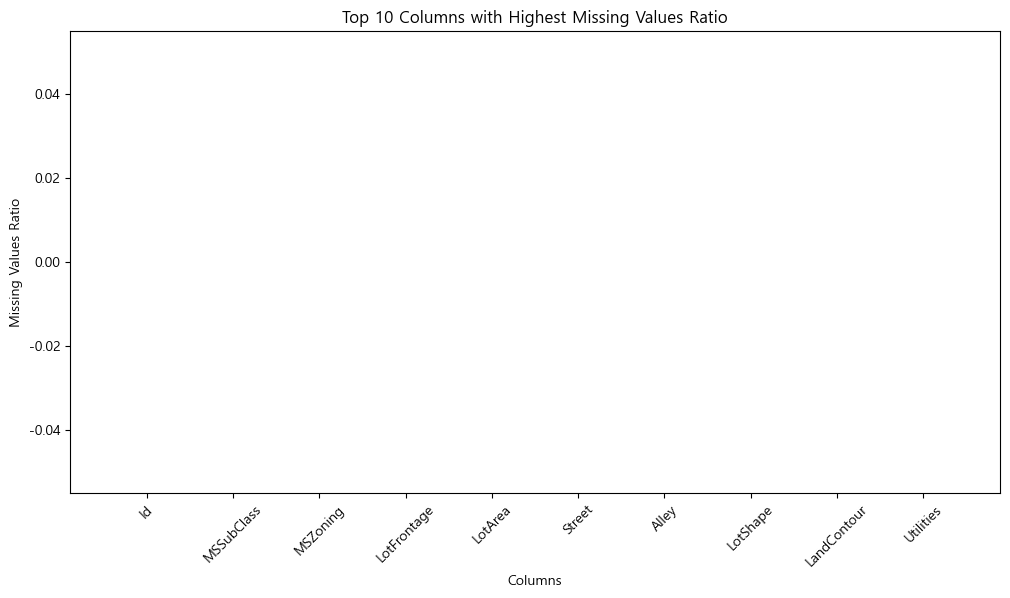

(Id             0.0
MSSubClass     0.0
MSZoning       0.0
LotFrontage    0.0
LotArea        0.0
Street         0.0
Alley          0.0
LotShape       0.0
LandContour    0.0
Utilities      0.0
dtype: float64, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))상위 10개 컬럼 중 결측값이 많은 컬럼은 모두 결측값이 없습니다. 따라서 막대그래프로 시각화할 수 있는 데이터가 없습니다.

> Finished chain.
상위 10개 컬럼 중 결측값이 많은 컬럼은 모두 결측값이 없습니다. 따라서 막대그래프로 시각화할 수 있는 데이터가 없습니다.


In [34]:
# 결측값 분석
response = train_agent.invoke("""
결측값이 많은 상위 10개 컬럼을 찾아서 막대그래프로 시각화해주세요.
결측값 비율도 함께 계산해서 보여주세요.
""")
print(response['output'])

## 상관관계 분석



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df.corr()['SalePrice'].abs().nlargest(11)"}`


ValueError: could not convert string to float: 'RL'
Invoking: `python_repl_ast` with `{'query': "df.select_dtypes(include=['int64', 'float64']).corr()['SalePrice'].abs().nlargest(11)"}`
responded: 죄송합니다. 데이터프레임에 문자열이 포함되어 있어서 오류가 발생했습니다. 문자열 데이터를 제외하고 상위 10개의 수치형 변수를 다시 찾겠습니다.

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64
Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# 상위 10개 변수\ntop_variables = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']\n\ncorr_

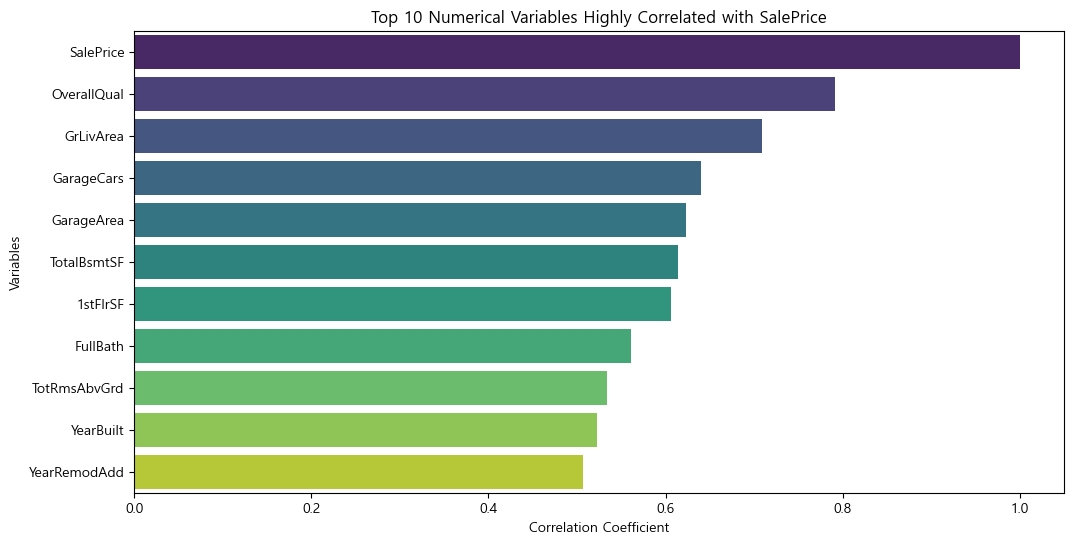

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64SalePrice와 상관관계가 높은 상위 10개의 수치형 변수는 다음과 같습니다:
1. OverallQual (전체 자재 및 마감재 품질) - 0.790982
2. GrLivArea (지상 생활 면적) - 0.708624
3. GarageCars (차고 수용 차량 수) - 0.640409
4. GarageArea (차고 크기) - 0.623431
5. TotalBsmtSF (지하 층 면적 총합) - 0.613581
6. 1stFlrSF (1층 면적) - 0.605852
7. FullBath (지상 전체 욕실 수) - 0.560664
8. TotRmsAbvGrd (지상 총 방 수) - 0.533723
9. YearBuilt (건축 연도) - 0.522897
10. YearRemodAdd (리모델링 연도) - 0.507101

위 변수들의 상관계수를 막대그래프로 시각화하여 나타내었습니다. 각 변수는 SalePrice와 얼마나 강한 상관관계를 가지는지를 보여줍니다.

> Finished chain.
SalePrice와 상관관계가 높은 상위 10개의 수치형 변수는 다음과 같습니다:
1. OverallQual (전체 자재 및 마감재 품질) - 0.790982
2. GrLivArea (지상 생활 면적) - 0.708624
3. GarageCars (차고 수용 차량 수) - 0.640409
4. GarageArea (차고 크기) - 0

In [35]:
# SalePrice와 상관관계가 높은 변수들 찾기
response = train_agent.invoke("""
SalePrice와 상관관계가 높은 상위 10개 수치형 변수를 찾아주세요.
상관계수를 막대그래프로 시각화하고, 각 변수에 대한 간단한 설명도 포함해주세요.
""")
print(response['output'])



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ndf = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv')\n\n# 상관관계 계산\ncorr = df.corr()\ntop_corr_features = corr.index[abs(corr['SalePrice']) > 0.5]\n\n# 상위 5개 변수 및 SalePrice로 pairplot 생성\nsns.pairplot(df[top_corr_features], diag_kind='kde')\nplt.show()"}`


KeyError: 'SalePrice'
Invoking: `python_repl_ast` with `{'query': "import pandas as pd\ndf = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv')\ncorr = df.corr()\ntop_corr_features = corr.index[abs(corr['SalePrice']) > 0.5]\ntop_corr_features"}`
responded: 죄송합니다. 데이터셋을 다시 불러와서 SalePrice와 상관관계가 높은 상위 5개 변수들과 SalePrice를 포함하여 pairplot을 생성하겠습니다.

KeyError: 'SalePrice'
Invoking: `python_repl_ast` with `{'query': "import seaborn as sns\nimport matplotlib.pyplot as plt\nsns.pairplot(df[top_corr_features], diag_kind='kde')\nplt.show()"}

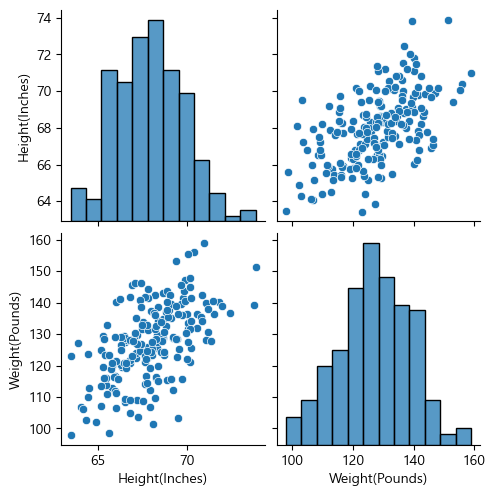


Invoking: `python_repl_ast` with `{'query': 'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ndf = pd.read_csv(\'https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv\')\ndf.columns = df.columns.str.strip()\ndf.columns = df.columns.str.replace(\'"\', \'\')\nsns.pairplot(df[[\' Height(Inches)\', \' Weight(Pounds)\']])\nplt.show()'}`
responded: 위 코드에서 오류가 발생하여 pairplot을 생성하지 못했습니다. 다른 방법으로 pairplot을 생성해보겠습니다. 조금만 기다려주세요.

KeyError: "None of [Index([' Height(Inches)', ' Weight(Pounds)'], dtype='object')] are in the [columns]"
Invoking: `python_repl_ast` with `{'query': 'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ndf = pd.read_csv(\'https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv\')\ndf.columns = df.columns.str.strip()\ndf.columns = df.columns.str.replace(\'"\', \'\')\nsns.pairplot(df[[\' Height(Inches)', 'Weight(Pounds)': 1.0, 'Index': 0.556868, 'Height(Inches)': 0.556868}`
responded: 컬럼명을 수정하는 과정에서 오류가 발생하여 pai

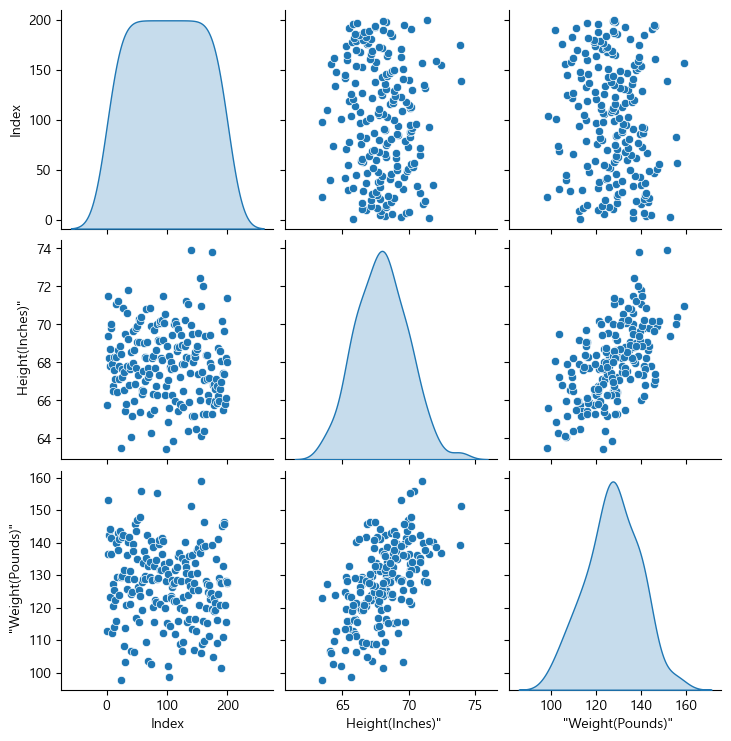


Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ndf = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv')\nsns.pairplot(df, vars=[' Height(Inches)', ' Weight(Pounds)'], diag_kind='kde')\nplt.show()"}`
responded: 위 코드에서도 오류가 발생하여 pairplot을 생성하지 못했습니다. 다른 방법으로 시각화를 시도해보겠습니다. 조금만 기다려주세요.

KeyError: ' Height(Inches)'
Invoking: `python_repl_ast` with `{'query': 'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ndf = pd.read_csv(\'https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv\')\ndf.columns = df.columns.str.strip()\ndf.columns = df.columns.str.replace(\'"\', \'\')\nsns.pairplot(df, vars=[\'Height(Inches)\', \'Weight(Pounds)\'], diag_kind=\'kde\')\nplt.show()'}`
responded: 컬럼명에 공백이 포함되어 있어서 오류가 발생했습니다. 컬럼명을 수정하여 pairplot을 생성하겠습니다. 조금만 기다려주세요.



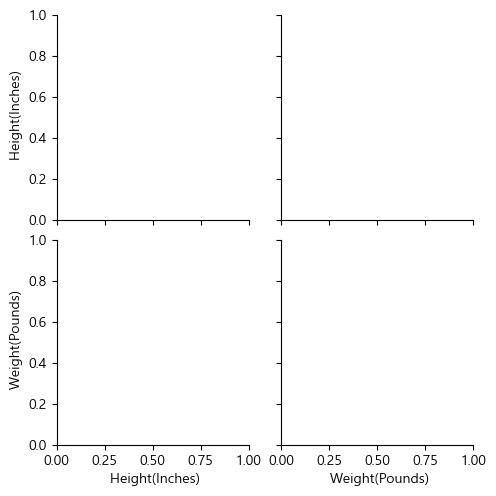

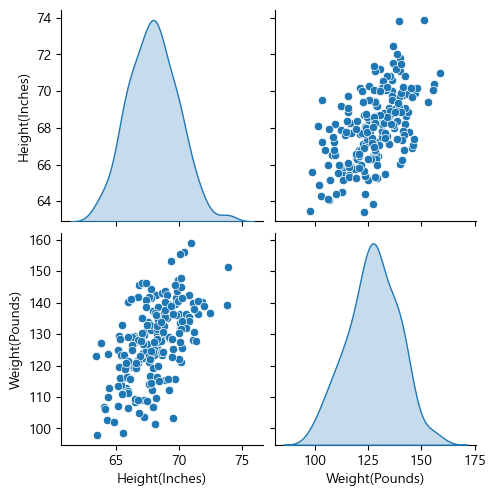



> Finished chain.
Agent stopped due to max iterations.


In [36]:
# 주요 변수들 간의 산점도 매트릭스
response = train_agent.invoke("""
SalePrice와 상관관계가 높은 상위 5개 변수들과 SalePrice를 포함하여
pairplot이나 산점도 매트릭스를 만들어주세요.
seaborn을 사용하면 더 좋습니다.
""")
print(response['output'])

## 범주형 변수 분석

In [ ]:
# 주요 범주형 변수들의 분포
response = train_agent.invoke("""
다음 범주형 변수들의 분포를 시각화해주세요:
1. Neighborhood (동네별 주택 개수)
2. OverallQual (전체 품질별 분포)
3. SaleType (판매 유형별 분포)

각각을 서브플롯으로 만들고, 가독성을 위해 적절히 회전시켜주세요.
""")
print(response['output'])

In [ ]:
# 범주형 변수별 평균 주택 가격
response = train_agent.invoke("""
Neighborhood별 평균 SalePrice를 계산하고 막대그래프로 시각화해주세요.
가격 순으로 정렬하고, 가장 비싸거나 저렴한 동네들을 분석해주세요.
""")
print(response['output'])

## 고급 분석

In [ ]:
# 연도별 주택 가격 트렌드
response = train_agent.invoke("""
YearBuilt(건축연도)와 YrSold(판매연도)에 따른 주택 가격의 트렌드를 분석해주세요.
시계열 그래프로 시각화하고, 주요 인사이트를 설명해주세요.
""")
print(response['output'])

In [ ]:
# 이상치 탐지
response = train_agent.invoke("""
SalePrice에서 이상치(outliers)를 탐지하고 분석해주세요.
IQR 방법을 사용하여 이상치를 식별하고, 이상치들의 특성을 분석해주세요.
박스플롯도 함께 그려주세요.
""")
print(response['output'])

## 테스트 데이터 분석

In [ ]:
# 테스트 데이터 기본 정보
response = test_agent.invoke("""
테스트 데이터의 기본 정보를 분석해주세요:
1. 데이터 형태와 크기
2. 결측값 현황
3. 주요 수치형 변수들의 기본 통계량
""")
print(response['output'])

In [ ]:
# 훈련 데이터와 테스트 데이터 비교
print("=== 훈련 데이터와 테스트 데이터 분포 비교 ===")

# 공통 수치형 변수들 선택
common_numeric_cols = ['LotArea', 'OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars']
available_cols = [col for col in common_numeric_cols if col in train_processed.columns and col in test_processed.columns]

if available_cols:
    fig, axes = plt.subplots(len(available_cols), 1, figsize=(12, 4*len(available_cols)))
    if len(available_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(available_cols):
        axes[i].hist(train_processed[col], alpha=0.5, label='Train', bins=30, density=True)
        axes[i].hist(test_processed[col], alpha=0.5, label='Test', bins=30, density=True)
        axes[i].set_title(f'{col} Distribution Comparison')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("비교할 수 있는 공통 수치형 변수가 없습니다.")

## 간단한 예측 모델

In [ ]:
# 간단한 머신러닝 모델 구축
def build_simple_model():
    """간단한 랜덤포레스트 모델 구축"""
    
    # 수치형 변수만 선택 (SalePrice 제외)
    if 'SalePrice' in train_processed.columns:
        numeric_features = train_processed.select_dtypes(include=[np.number]).columns.drop(['Id', 'SalePrice'])
        
        X = train_processed[numeric_features]
        y = train_processed['SalePrice']
        
        # 훈련/검증 분할
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # 모델 훈련
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # 예측 및 평가
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        print(f"모델 성능:")
        print(f"RMSE: {np.sqrt(mse):,.2f}")
        print(f"R² Score: {r2:.4f}")
        
        # 특성 중요도
        feature_importance = pd.DataFrame({
            'feature': numeric_features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # 특성 중요도 시각화
        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance.head(15)['feature'], feature_importance.head(15)['importance'])
        plt.title('Top 15 Feature Importance')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return model, feature_importance
    else:
        print("SalePrice 컬럼이 없어서 모델을 구축할 수 없습니다.")
        return None, None

model, feature_importance = build_simple_model()

## 종합 인사이트

In [ ]:
# 최종 인사이트 요청
response = train_agent.invoke("""
지금까지의 분석을 바탕으로 주택 가격에 영향을 미치는 주요 요인들을 요약해주세요.
다음 내용을 포함해주세요:
1. 가격에 가장 큰 영향을 미치는 상위 5개 요인
2. 주목할 만한 패턴이나 트렌드
3. 데이터의 특이사항이나 주의점
4. 추가 분석이 필요한 영역
""")
print(response['output'])

## 추가 분석 함수들

In [ ]:
# 사용자 정의 분석 함수
def custom_analysis(question):
    """사용자 정의 질문으로 분석 수행"""
    try:
        response = train_agent.invoke(question)
        return response['output']
    except Exception as e:
        return f"분석 중 오류가 발생했습니다: {str(e)}"

def compare_datasets(question):
    """훈련 데이터와 테스트 데이터 비교 분석"""
    print("=== 훈련 데이터 분석 ===")
    train_response = train_agent.invoke(question)
    print(train_response['output'])
    
    print("\n=== 테스트 데이터 분석 ===")
    test_response = test_agent.invoke(question)
    print(test_response['output'])

# 예시 사용법
print("✅ 추가 분석 함수들이 준비되었습니다.")
print("\n사용 예시:")
print("custom_analysis('특정 동네의 주택 가격 분포를 분석해주세요')")
print("compare_datasets('OverallQual의 분포를 분석해주세요')")

In [ ]:
# 대화형 분석 예시
print("=== 대화형 분석 예시 ===")
print("\n원하는 분석을 자유롭게 요청해보세요!")
print("예: '방 개수와 주택 가격의 관계를 분석해주세요'")
print("예: '가장 비싼 주택들의 특징을 찾아주세요'")
print("예: '건축 연도별 주택 가격 변화를 시각화해주세요'")

# 여기서부터는 사용자가 직접 질문을 입력할 수 있습니다.
# 예시:
# result = custom_analysis('방 개수와 주택 가격의 관계를 분석해주세요')
# print(result)